# Blind Source Separation
## Independent Component Analysis

## The Cocktail Party Problem (CPP)

## Statistical Independence

We said that voices are independent because listening to one won't allow us to predict the other. 

To exploit this property mathematically, we construct the **probability density functions(pdf)** for each of the signals that our **m** microphones have recorded. 

In the context of the Cocktail Party Problem, we use pdfs to quantify statistical independence. There are many ways of quantifying the independence of two random variables if their pdfs are known. This is why we are working with probability density functions. 

Here comes an extremely important point: While solving the Cocktail party problem, we assume that all the source signals that we wish to recover are non-Gaussian.

It means that the pdf of each source signal is not a Gaussian function/distribution.


We invoke Information theory to justify our assumption. Simply put, there is a result in Information theory that says that the **Gaussian distribution has the greatest possible entropy (for a fixed variance of the distribution).** Entropy in our context is just disorder. The source signals do have order, as they contain lots of information. If they were purely Gaussian, then the signals would just sound like (Gaussian) noise. 

An intuitive understanding of why this result *should be right* can be acquired by considering the famous Galton box(bean machine).

![Galton Box GIF](Notebook/galton_board.gif)
![Galton Box](Notebook/galton_board.jpg)
<center>Courtesy:http://tyulpinova.ru/normal_distribution/#</center>
This is the epitome of a random process(that contains no information) and the fact that it has a Gaussian distribution is confirmation(if not justification) of the fact that the Guassian distribution has the greatest entropy. 


Hence we assume that the original source signals have non-Gaussian distributions.

This revelation about the nature of the pdfs of the source signals actually allows us to solve the entire problem! We reiterate that each of the recorded signals is a linear sum of the original source signals. We now invoke the **Central Limit Theorem**.

The central limit theorem says that the pdf (of the average) of the sum of independent random variables, tends to a Gaussian distribution, as the number of random variables tend to infinity. Why is this important here? Well, we have assumed that the source signals are non-Gaussian independent variables and that the recorded signals are linear weighted sums of these non-Gaussian variables. By the Central Limit Theorem, the sum of non-Gaussian variables is more Gaussian than the individual variables. Hence, the recorded signals are more Gaussian than the source signals!  

We finally have a way to recover our original signals. Remember that we are trying to *linearly transform* the recorded signals back to the source signals. Thus, now we have to just find the linear transformation that minimises the "Gaussian nature" of the transformed signals. The signals that have the least "Gaussian nature" simply correspond to our source signals.

Notice that I have put "Guassian nature" in quotes. This is because we have not yet quantified deviations from a Gaussian distribution. Indeed, this is precisely where FOBI and fastICA (and other ICA implementations) differ from one another. The steps that we have outlined in the previous sections apply to both. But the subsequent sections elucidate two different approaches to quantifying deviations from a Gaussian distribution and the details of the solutions to the Cocktail Party Problem formulated based on them.
***

## fastICA

The first method that we will be discussing is known as the fastICA which uses two important algorithms used widely in numerical analysis - _gradient descent_ and _fixed-point iteration_. An understanding of both these is very important and hence we shall be discussing these before we encounter the actual algorithm. As a brief, we must estimate the matrix $W$ such that the source matrix $s = Wx$ has minimum _'statistical dependence'_. To quantify the stastical dependence/independence, we use the concept of a _cost function_. We must choose the matrix $W$ which minimises the cost function, and hence maximises statistical independence. Fasten your seat belts, as we dive into the world of _Machine Learning_ and tackle the topics one at a time, eventually solving the Cocktail Party Problem. 

### The Cost Function

We've talked all about optimising the function and solving for its optimal value and roots etc. _But hey!_ In the problem that we were discussing where is this ___function___? In this section we'll see how we can choose a function, whose optimisation gives us the desired result - separated sources.

In any optimisation problem of this sort, we talk about a term called the __cost__, which (in the case of a minimisation) is analogous to the price you are paying by deviating from ideal results. A similar analogy can be thought of for maximisation. Hence, we must quantify the property _statistical dependence_ and minimise it for the sources to be best separated. _Note that the ideal case of perfect separation can generally not be attained due to various limitations_. So, how do we quantify this dependence, or _Gaussianity_, as discussed in the last topic?
* __Kurtosis__ is defined as the normalized form of the fourth central moment of a distribution. $$ kurt(x)=E(x^4) - 3(E(x^2))^2 $$ If we assume $x$ to have zero mean  $\mu_x=E\{x\}=0$ and unit variance  $\sigma^2_x=E\{x^2\}-\mu_x^2=1$, then $E\{x^2\}=1$ and  $kurt(x)=E\{x^4\}-3$. Kurtosis measures the degree of peakedness (spikiness) of a distribution and it is zero only for Gaussian distribution. Any other distribution's kurtosis is either positive if it is supergaussian (spikier than Gaussian) or negative if it is subgaussian (flatter than Gaussian). Therefore the absolute value of the kurtosis or kurtosis squared can be used to measure the non-Gaussianity of a distribution. However, kurtosis is very sensitive to outliers, and it is not a robust measurement of non-Gaussianity. ![](http://fourier.eng.hmc.edu/e161/lectures/figures/kurtosis.gif)
<center>Courtesy: [Harvey Mudd College](https://www.hmc.edu/) Lectures</center>
Hence, maximising this _kurtosis_ function can be our optimisation objective!

* __Differential Entropy _(Negentropy)___: Entropy is a very complex concept, which we wish to skip here, but as a fact, an important result in Information Theory states that the Gaussian Distribution the maximum entropy among all distributions over the entire real axis  $(-\infty,\infty)$. Thus, it can be used as a measure of _Gaussianity_. For more information on this, you can refer to [this site](http://fourier.eng.hmc.edu/e161/lectures/ica/node4.html).

### fastICA Algorithm

Pheww! That was long! Now let's finally take a look at the fastICA algorithm in a brief manner.

1. Obtain the data matrix $x$.

2. Subtract off the mean to center $x$.

3. Whiten the matrix $x$ to obtain the matrix $x^T$.
1. Choose a random guess for the initial value of the de-mixing matrix ${\bf w}$.
2. Iterate the following: $$ w \gets E(xg(w^Tx)) - E(g'(w^Tx))w $$ You will realise that this step is in fact the implementation of gradient descent using fixed-point iteration, as discussed above! The function $g$ is a function used to capture higher order features of the matrix $w^Tx$ and is similar to capturing the negentropy.
3. Normalize ${\bf w}$ $$ w \gets w/{\|w\|} $$
4. If not converged, go back to 2.

Convergence can be judged by the fact that an ideal $w$ would be orthogonal, and hence $w_i^Tw_{i+1}$ would $\approx 1$. We thus use this condition to examine convergence.

The gradient descent step uses a function $g$ which can be a function like $cosh(x)$ or $tanh(x)$ which capture higher order correlations and hence we finally aim to maximise the function $\Sigma E(g(y_i))$ where $y_i = {\bf w_i^Tx}$ is a component of ${\bf y = Wx}$.

In [1]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from scipy.io import wavfile
from scipy import linalg as LA
from numpy.random import randn as RNDN
from IPython.display import Audio

Sampling rate=  8000
Data type is  uint8
Number of samples:  50000


Text(0.5,1,'Whitened data')

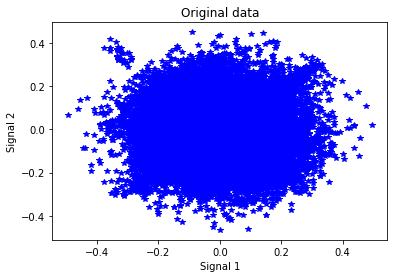

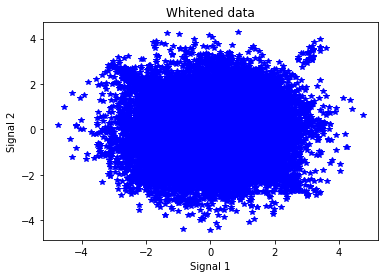

In [2]:
%matplotlib inline
"""
Cocktail Party Problem solved via Independent Component Analysis.
The fastICA algorithm is implemented here,
using negentropy as a measure of non-gaussianity.
"""
# Dimension
dim = 2

# Input the data from the first receiver.
samplingRate, signal1 = wavfile.read('fastICA/mic1.wav')
print("Sampling rate= ", samplingRate)
print("Data type is ", signal1.dtype)

# Convert the signal so that amplitude lies between 0 and 1.
# uint8 takes values from 0 through 255; sound signals are oscillatory
signal1 = signal1 / 255.0 - 0.5

# Output information about the sound samples.
a = signal1.shape
n = a[0]
print( "Number of samples: ", n)
n = n * 1.0

# Input data from the first receiver and standardise it's amplitude.
samplingRate, signal2 = wavfile.read('fastICA/mic2.wav')
signal2 = signal2 / 255.0 - 0.5

# x is our initial data matrix.
x = [signal1, signal2]

# Plot the signals from both sources to show correlations in the data.
plt.figure()
plt.plot(x[0], x[1], '*b')
plt.ylabel('Signal 2')
plt.xlabel('Signal 1')
plt.title("Original data")

# Calculate the covariance matrix of the initial data.
cov = np.cov(x)
# Calculate eigenvalues and eigenvectors of the covariance matrix.
d, E = LA.eigh(cov)
# Generate a diagonal matrix with the eigenvalues as diagonal elements.
D = np.diag(d)

Di = LA.sqrtm(LA.inv(D))
# Perform whitening. xn is the whitened matrix.
xn = np.dot(Di, np.dot(np.transpose(E), x))

# Plot whitened data to show new structure of the data.
plt.figure()
plt.plot(xn[0], xn[1], '*b')
plt.ylabel('Signal 2')
plt.xlabel('Signal 1')
plt.title("Whitened data")

Text(0.5,1,'Original signal 2')

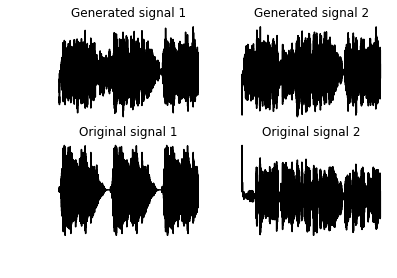

In [3]:
def g(x):
    out = np.tanh(x)
    return out


def dg(x):
    out = 1 - g(x) * g(x)
    return out

# Now that we have the appropriate signal,
# we proceed to implement fastICA on the source signal 'x'

# Creating random weight vector
w1 = RNDN(dim, 1)
w1 = w1 / LA.norm(w1)

w0 = RNDN(dim, 1)
w0 = w0 / LA.norm(w0)


# Running the fixed-point algorithm, with gradient descent
epsilon = 0.01  # Determines the extent of convergence
alpha = 1  # Step-size for gradient-descent

while (abs(abs(np.dot(np.transpose(w0), w1)) - 1) > epsilon):
    w0 = w1
    w1 = np.dot(xn, np.transpose(g(np.dot(np.transpose(w1), xn)))) / \
        n - alpha * \
        np.transpose(np.mean(np.dot(dg(np.transpose(w1)), xn), axis=1)) * w1
    w1 = w1 / LA.norm(w1)

w2 = RNDN(dim, 1)
w2 = w2 / LA.norm(w2)

w0 = RNDN(dim, 1)
w0 = w0 / LA.norm(w0)

while (abs(abs(np.dot(np.transpose(w0), w2)) - 1) > 0.01):
    w0 = w2
    w2 = np.dot(xn, np.transpose(g(np.dot(np.transpose(w2), xn)))) / \
        n - alpha * \
        np.transpose(np.mean(np.dot(dg(np.transpose(w2)), xn), axis=1)) * w2
    w2 = w2 - np.dot(np.transpose(w2), w1) * w1
    w2 = w2 / LA.norm(w2)

# Forming the source signal matrix
w = np.transpose([np.transpose(w1), np.transpose(w2)])
s = np.dot(w, x)

# Plot the separated sources.
time = np.arange(0, n, 1)
time = time / samplingRate
time = time * 1000  # convert to milliseconds

plt.figure()
plt.subplot(2, 2, 1).set_axis_off()
plt.plot(time, s[0][0], color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Generated signal 1")

plt.subplot(2, 2, 2).set_axis_off()
plt.plot(time, s[1][0], color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Generated signal 2")

# Plot the actual sources for comparison.
samplingRate, orig1 = wavfile.read('fastICA/source1.wav')
orig1 = orig1 / 255.0 - 0.5  # uint8 takes values from 0 to 255

plt.subplot(2,2, 3).set_axis_off()
plt.plot(time, orig1, color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Original signal 1")

samplingRate, orig2 = wavfile.read('fastICA/source2.wav')
orig2 = orig2 / 255.0 - 0.5  # uint8 takes values from 0 to 255

plt.subplot(2, 2, 4).set_axis_off()
plt.plot(time, orig2, color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Original signal 2")

To represent the audio files is through a spectrogram (short time fourier transform)

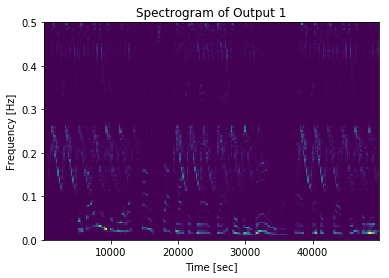

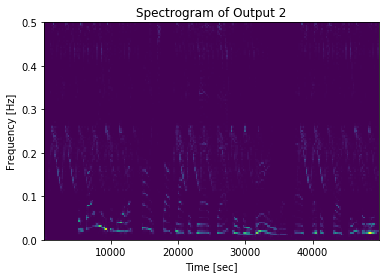

In [4]:
plt.figure()
f, t, S = signal.spectrogram(s[0][0])
plt.pcolormesh(t, f, S)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Output 1')

plt.figure()
f, t, S = signal.spectrogram(s[1][0])
plt.pcolormesh(t, f, S)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Output 2')

# Storing numpy array as audio
wavfile.write('fastICA/out1.wav', samplingRate, np.transpose(s[0][0]))
wavfile.write('fastICA/out2.wav', samplingRate, np.transpose(s[1][0]))

In [5]:
print('Mixed Signal 1')
Audio("fastICA/mic1.wav")

Mixed Signal 1


In [6]:
print('Mixed Signal 2')
Audio("fastICA/mic2.wav")

Mixed Signal 2


In [7]:
print('Original separated signal 1')
Audio("fastICA/source1.wav")

Original separated signal 1


In [8]:
print('Original separated signal 2')
Audio("fastICA/source1.wav")

Original separated signal 2


In [9]:
print('Separated signal 1 (output)')
Audio("fastICA/out1.wav")

Separated signal 1 (output)


In [10]:
print('Separated signal 2 (output)')
Audio("fastICA/out2.wav")

Separated signal 2 (output)


## <font color='blue'>FOBI</font>

FOBI stands for Fourth Order Blind Identification. 

As the name suggests, it is based on considering fourth order moments and using them as a metric for Gaussianity. 
Covariance, variance and the covariance matrix are second order moments. 
Fourth order moments are usually referred to by the term kurtosis. There are other ICA methods that explicitly work with kurtosis, but not so with FOBI. 

FOBI is a very elegant method that works without the need to search a solution space for the indepenedent components(as is the case with fastICA and other negentropy or maximum-likelihood based ICA approaches). Rather, it provides an explicit algebraic formula for the independent components. 

It has some striking and appealing similarities to PCA. FOBI is based on the following amazing fact:

**The weights of the independent components are the eigenvectors of the matrix $cov(|X'|X')$. **

The statement requires some explanation. 
$X'$ is the matrix obtained after preprocessing $X$ (mean-centered and whitened).

$|X'|$ needs to be explained. Remember that each column of $X'$ corresponds to the (whitened) set of amplitudes recorded at some instant of time by the **m** microphones. If we take this column to be a vector, then the norm (aka the modulus) of this vector is well defined. We find the norm of each column of **X'** and put these calculated norms in a row matrix. This is the matrix $|X'|$. 
Hence, $|X'|$ is simply the norm of the matrix $X$ taken along the "column-axis".

But here comes a caveat: The matrix $|X'|X'$ is not formed by the normal matrix multiplication between $|X'|$ and $X'$. We have written it this way only for notational convnenience. Instead, we are using the elements of $|X'|$ as weights for the columns of $X'$. That is, the matrix $|X'|X'$ is formed as follows:

The **i**th column of $|X'|X'$ is formed by a scalar multiplication of the **i**th element of the **1 x m** row matrix $|X'|$ with the **i**th column of the **m x n** matrix $X'$ (each element within this column is thus multiplied by the same scalar value equal to the **i**th element of $|X'$).   

Hence, $|X'|X'$ is a weighted version of $X'$. It is easy to think of each column of $X'$ as a vector in an m-dimensional space. Then $|X'|$ contains the norms of the **m** columns of $X'$ i.e vectors. Multiplying each vector (column) by it's norm and storing these column vectors as columns in a new matrix yields $|X'|X'$.

And what does the statement itself mean? Well, remember how we said that $X = AS$. After whitening, we can say that $X' = A'S'$.
Here, $S'$ corresponds to the source signals itself, but their amplitude has been normalised. (Recall how ICA can only recover the signals upto to a multiplicative factor.)  

The columns of $A'$ are the weights being referred to in the statement above. They are called weights because the each row of $S'$ is a source signal. Upon performing matrix multiplication between $A'$ and $S'$, we can see that $X' = \sum_{1}^{m}A'_{i}S'_{i}$. Note that $A'_{i}$ are column vectors and $S'_{i}$ are row vectors. Hence, the columns of $A'$ act as weights for the source signals. 

Hence, FOBI allows us to directly compute the matrix $A'$ which as expected, turns out to be orthogonal. (The result says that the columns of $A'$ are orthogonal eigenvectors of the matrix $cov(|X'|X')$. Hence, $A'$ is an orthogonal matrix.) Finding the signals is now trivial. $S' = A'^{-1}X' = A'^{T}X'$. (The inverse of an orthogonal matrix is simply it's transpose.)

Recall that in PCA, the principal components were eigenvectors of the matrix $cov(X)$ and they were all orthogonal. Here, the columns of $A'$, which are the weights for the source signals are the eigenvectors of the matrix  $cov(|X'|X')$. And the weights are orthogonal to one another! 

The proof of this result and a good explanation of the FOBI algorithm can be found in the original paper by the inventor of the FOBI algorithm Jean Cardoso, [here](http://perso.telecom-paristech.fr/~Cardoso/Papers.PDF/icassp89.pdf). The notation used in the paper is rather different from the one that we have been using so far and can be rather confusing. The proof itself is however extremely elegant. 

Also, refer to the paper to better understand why it involves fourth order moments. Basically, if $X'$ were a simple vector, then $cov(|X'|X')$ is fourth order in $X'$. This extends to $X'$ being a matrix.

So the FOBI algorithm in summary is:  

1) Obtain the data matrix *X*.

2) Subtract off the mean to center *X*.

3) Whiten the matrix *X* to obtain the matrix *X'*.

4) Compute the matrix  $cov(|X'|X')$. 

5) Find the eigenvectors of  $cov(|X'|X')$.

6) Store the eigenvectors as columns of a matrix $Y$. ($Y$ is just $A'$)

7) Retrieve the original signals as $S' = Y^{T}X'$. 


The code for the solvong the Cocktail Party Problem based on the FOBI algorithm is given below. In the code, we have used slightly different notation in some places. For instance, x for X and xn for X'. 

Sampling rate =  8000
Data type is  uint8
Number of samples:  50000


Text(0.5,1,'Whitened data')

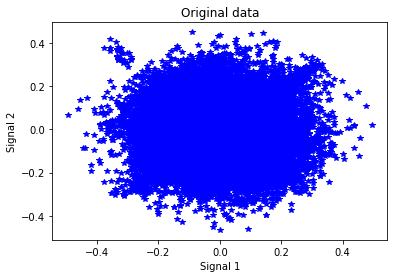

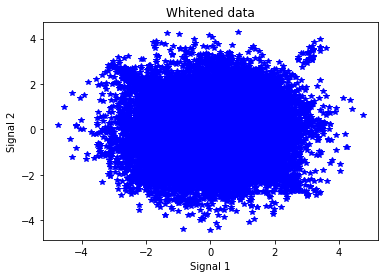

In [12]:
%matplotlib inline
"""
Cocktail Party Problem solved via Independent Component Analysis.
The Fourth Order Blind Identification(FOBI) ICA is implemented here.
"""
# Import packages.
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from scipy.io import wavfile
from scipy import linalg as LA

# Input the data from the first receiver.
samplingRate, signal1 = wavfile.read('FOBI/Sounds/mix1.wav')
print("Sampling rate = ", samplingRate)
print("Data type is ", signal1.dtype)

# Convert the signal so that amplitude lies between 0 and 1.
signal1 = signal1 / 255.0 - 0.5  # uint8 takes values from 0 to 255

# Output information about the sound samples.
a = signal1.shape
n = a[0]
print("Number of samples: ", n)
n = n * 1.0

# Input data from the second receiver and standardise it's amplitude.
samplingRate, signal2 = wavfile.read('FOBI/Sounds/mix2.wav')
signal2 = signal2 / 255.0 - 0.5  # uint8 takes values from 0 to 255

# x is our initial data matrix.
x = [signal1, signal2]

# Plot the signals from both sources to show correlations in the data.
plt.figure()
plt.plot(x[0], x[1], '*b')
plt.ylabel('Signal 2')
plt.xlabel('Signal 1')
plt.title("Original data")

# Calculate the covariance matrix of the initial data.
cov = np.cov(x)
# Calculate eigenvalues and eigenvectors of the covariance matrix.
d, E = LA.eigh(cov)
# Generate a diagonal matrix with the eigenvalues as diagonal elements.
D = np.diag(d)

Di = LA.sqrtm(LA.inv(D))
# Perform whitening. xn is the whitened matrix.
xn = np.dot(Di, np.dot(np.transpose(E), x))

# Plot whitened data to show new structure of the data.
plt.figure()
plt.plot(xn[0], xn[1], '*b')
plt.ylabel('Signal 2')
plt.xlabel('Signal 1')
plt.title("Whitened data")


Text(0.5,1,'Original signal 2')

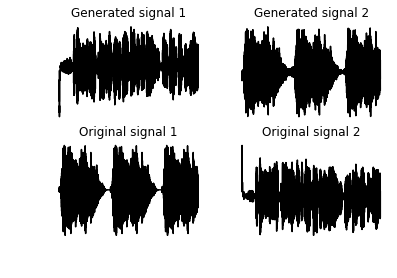

In [13]:
# Perform FOBI.
norm_xn = LA.norm(xn, axis=0)
norm = [norm_xn, norm_xn]

cov2 = np.cov(np.multiply(norm, xn))

d_n, Y = LA.eigh(cov2)

source = np.dot(np.transpose(Y), xn)

# Plot the separated sources.
time = np.arange(0, n, 1)
time = time / samplingRate
time = time * 1000  # convert to milliseconds

plt.figure()
plt.subplot(2, 2, 1).set_axis_off()
plt.plot(time, source[0], color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Generated signal 1")

plt.subplot(2, 2, 2).set_axis_off()
plt.plot(time, source[1], color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Generated signal 2")

# Plot the actual sources for comparison.
samplingRate, orig1 = wavfile.read('FOBI/Sounds/source1.wav')
orig1 = orig1 / 255.0 - 0.5  # uint8 takes values from 0 to 255

plt.subplot(2, 2, 3).set_axis_off()
plt.plot(time, orig1, color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Original signal 1")

samplingRate, orig2 = wavfile.read('FOBI/Sounds/source2.wav')
orig2 = orig2 / 255.0 - 0.5  # uint8 takes values from 0 to 255

plt.subplot(2, 2, 4).set_axis_off()
plt.plot(time, orig2, color='k')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.title("Original signal 2")

Again we plot the spectrograms

In [ ]:
plt.figure()
f, t, S = signal.spectrogram(source[0])
plt.pcolormesh(t, f, S)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Output 1')

plt.figure()
f, t, S = signal.spectrogram(source[1])
plt.pcolormesh(t, f, S)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Output 2')

# Storing numpy array as audio
wavfile.write('FOBI/Sounds/out1.wav', samplingRate, np.transpose(source[0]))
wavfile.write('FOBI/Sounds/out2.wav', samplingRate, np.transpose(source[1]))

In [ ]:
from IPython.display import Audio
print('Mixed Signal 1')
Audio("FOBI/Sounds/mix1.wav")

In [ ]:
print('Mixed Signal 2')
Audio("FOBI/Sounds/mix2.wav")

In [ ]:
print('Original separated sound 1')
Audio("FOBI/Sounds/source1.wav")

In [ ]:
print('Original separated sound 2')
Audio("FOBI/Sounds/source2.wav")

In [ ]:
print('Separated signal 1 (output)')
Audio("FOBI/Sounds/out1.wav")

In [ ]:
print('Separated signal 1 (output)')
Audio("FOBI/Sounds/out2.wav")

### fastICA v/s FOBI

The comparison of different implementations of ICA is very difficult as there are few parameters available to quantify and compare performance, and even then no one algorithm performs better unilaterally in all scenarios. Such metrics are usually thus compiled for data from highly specific domains. 

However, some broad conclusions have been drawn based on the asymptotic behaviour of algorithms.

Alogrithms can be categorised on the basis of how of how Gaussianity is quantified. 

fastICA is based on negentropy. Maximum-likelihood and negenrtropy are considered optimal in their statistical properties. However, nengentropy is very computationally expensive to compute if the actual formula is used without any approximations. Hence, in practice, approximate formulae for negentropy are used. These approximations are a compromise between computational speed and statistical properties. 

FOBI does not explicitly use a cost function at all. It provides a purely algebraic method of implementing ICA. Yet, it's statistical properties are essentially that of Kurtosis and it implicitly uses fourth order moments. Kurtosis suffers from non-optimal dependence on outliers. FOBI in particular also involves a lot of matrix computations that might not scale well with the size of the data. 


## Limitations of ICA

ICA generates the independent components upto a scaling factor. This means that the output can also be 'flipped' due to scaling by a negative number. This does not matter when it comes to sound signals but may be a problem to be rectified in other applications of ICA. 

ICA works very well when there is no noise. Noisy ICA methods have been developed that assume a Gaussian pdf for the noise. This is a reasonabel assumption to make in most cases but does not hold always hold.

ICA works on linear models. Why?

Often, the components estimated from data by an ICA algorithm are not independent. Why?

Empirical results tend to show that ICA estimation seems to be rather robust against some violations of the independence assumption. Why?

## Conclusion

It is fair to say that ICA has become a standard tool in machine learning and signal processing. The generality and potential usefulness of the model were never in question, but in the early days of ICA, there was some doubt about the adequacy of the assumptions of non-Gaussianity and independence. 

It has been realized that non-Gaussianity is in fact quite widespread in any application dealing with scientific measurement devices (as opposed to, for example, data in the social and human sciences). On the other hand, independence is now being seen as a useful approximation that is hardly ever strictly true. Fortunately, it does not need to be strictly true because most ICA methods are relatively robust regarding some dependence of the components.